## About the Fashion-MNIST dataset
The ```Fashion-MNIST``` dataset is a collection of images of fashion items, like T-shirts, dresses, shoes etc. It consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [16]:
# example of loading the fashion mnist dataset
from matplotlib import pyplot
from keras.datasets import fashion_mnist
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout)
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

### Loading the dataset
We first call ```load_data()``` from ```tensorflow.keras.datasets.fashion_mnist``` which returns 2 tuples for the training and test images, as well as the labels respectively.

In [3]:
# Step 1: load train and test dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print('Before preprocessing:')
print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))

4431872/4422102 [==============================] - 0s 0us/step
Before preprocessing:
 - X_train.shape = (60000, 28, 28), y_train.shape = (60000,)
 - X_test.shape = (10000, 28, 28), y_test.shape = (10000,)


### Preprocessing the data
1. Shuffle the train and test sets to get rid of any kind of implicit sorting.
2. Create cross validation and test data sets.
3. Set aside a copy of the test set ```X_test/y_test``` before applying any pre-processing steps for visualization.
> Cross validation is where the model is trained on the training data set & its performance evaluated on a cross-validation data on each epoch of training.

I will randomly split the 10,000 samples from ```X_test/y_test``` into 8,000 samples for the cross validation set ```X_val/y_val```, and 2,000 samples for the test set ```X_test/y_test```.

In [4]:
# Step 2: split the X_test/y_test dataset into cross-val & test datasets
# Split X_test/y_test into cross-validation & test datasets.
# We have 10,000 samples in X_test/y_test - we will assign 8,000 to X_val/y_val & the
# remaining 2,000 to X_test/y_test (test dataset) AFTER randomly sorting the dataset

# randomly sort X_test/y_test
indexes = np.arange(X_test.shape[0])
for _ in range(5): 
  indexes = np.random.permutation(indexes)  # shuffle 5 times!
X_test = X_test[indexes]
y_test = y_test[indexes]

# 'split' into cross-val & test sets (use 8000 records in cross-val set)    
val_count = 8000
X_val = X_test[:val_count]
y_val = y_test[:val_count]
X_test = X_test[val_count:]
y_test = y_test[val_count:]

# keep an non pre-processed copy of X_test/y_test for visualization
test_images, test_labels = X_test.copy(), y_test.copy()

Scale the images ```X_train, X_val & X_test``` to floats between 0 and 1. Models train faster on data on uniform and small scales.

In [5]:
# Step 3: scale pixels

# convert from integers to floats
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


Finally, reshape the image datasets into 3D tensors of shape ```(no_of_images, image_height, image_width, no_of_channels)``` as expected by CNN.

In [6]:
# Step 4 : Reshape the images

# reshape dataset to have a single channel
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

print('After preprocessing:')
print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
print(' - test_images.shape = {}, test_labels.shape = {}'.format(test_images.shape,
    test_labels.shape))

After preprocessing:
 - X_train.shape = (60000, 28, 28, 1), y_train.shape = (60000,)
 - X_val.shape = (8000, 28, 28, 1), y_val.shape = (8000,)
 - X_test.shape = (2000, 28, 28, 1), y_test.shape = (2000,)
 - test_images.shape = (2000, 28, 28), test_labels.shape = (2000,)


In [17]:
# Display a random selection of images & corresponding labels
# The display is laid out in a grid of num_rows x num_col cells
def display_sample(sample_images, sample_labels, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
  
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index], cmap="Greys")

                # show the actual labels in the cell title
                title = ax[r, c].set_title("%s" % FASHION_LABELS[sample_labels[image_index]])
               
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

### Viewing a sample of the dataset
Here is a random sample of 50 images from ```test_images``` and ```test_labels```, presented in a 5x10 grid.

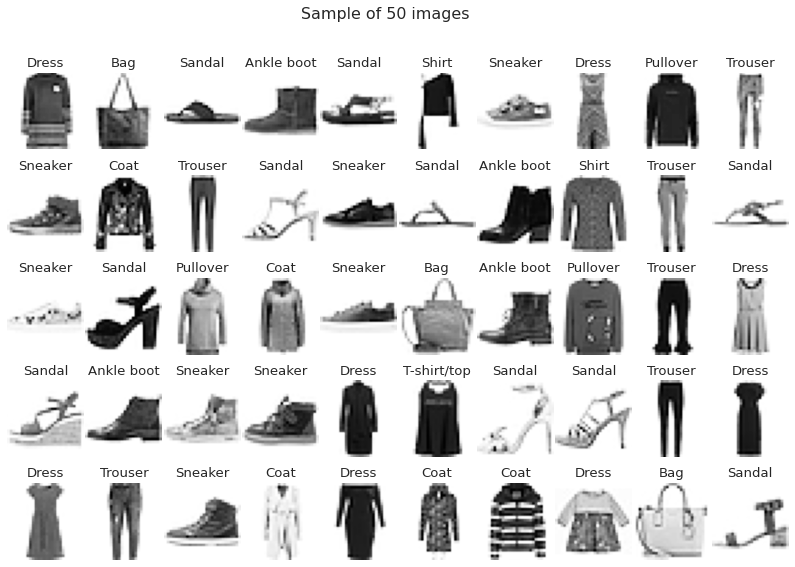

In [ ]:
sample_size = 50
rand_indexes = np.random.randint(0, len(X_test), sample_size)
sample_images = test_images[rand_indexes]
sample_labels = test_labels[rand_indexes]
display_sample(sample_images, sample_labels, 
               plot_title='Sample of %d images' % sample_size)

In [7]:
def plotLossAccGraph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    # ax1.set_ylim(bottom=0.0, top=0.6)
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    # ax2.set_ylim(bottom=0.85, top=1.0)
    ax2.legend()

    plt.show()

### Building a baseline model
Here I built a simple baseline model consisting of a single convolutional layer and a single dense layer of 100 units, with a ```softmax``` activation function. I did not perform one-hot encoding on my labels ```y_train/y_test``` and left them as integers to save time in memory as well as computation. As a result, I used ```sparse_categorical_crossentropy``` as my loss function because it simply uses a single integer for a class, rather than a whole vector.

In [ ]:
# define cnn model (baseline)
def define_model():
    model = tf.keras.Sequential([
        # first convolutional layer
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2,2)),

        # fully connected classifier
        Flatten(), 
        Dense(100, activation='relu'), 
        Dense(10, activation='softmax')
    ])
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

### Training the model
My model training process is as follows:
1. Train the model with the cross-validation technique where the model is trained on the entire training dataset ```(X_train/y_train)``` and its performance cross-validated on the cross-val ```(X_val/y_val)``` data per epoch.
2. Next, plot the training and cross-validation losses vs epochs and training & cross-validation accuracies vs epochs.
3. Finally, I evaluated the model’s performance on the test data ```(X_test/y_test)``` which gives an independent evaluation of my model’s performance since the model has never seen the 'holdout' test data.

In [ ]:
# Training our model
# train on X_train/y_train & cross-validate on X_val/y_val
model = define_model()
model.summary()
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 100)               540900    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
__________________________________________________

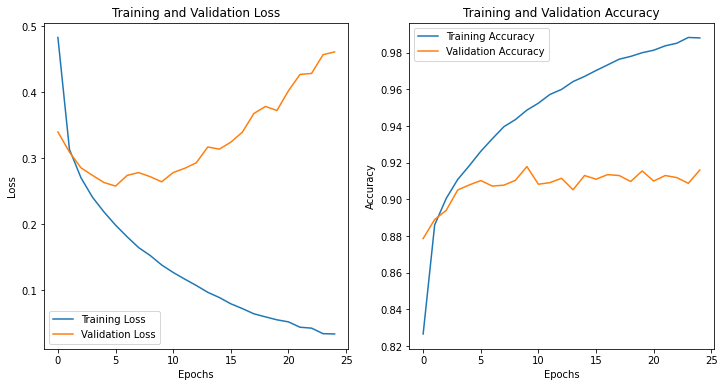

In [ ]:
plotLossAccGraph(history)

In [ ]:
# Evaluating performance on train dataset
loss, acc = model.evaluate(X_train, y_train)
print('  - Train data: loss %.3f - acc %.3f' % (loss, acc))

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0285 - accuracy: 0.9901
  - Train data: loss 0.028 - acc 0.990


In [ ]:
# Evaluating performance on cross-validation dataset
loss, acc = model.evaluate(X_val, y_val)
print('  - Cross-val data: loss %.3f - acc %.3f' % (loss, acc))

250/250 [==============================] - 1s 2ms/step - loss: 0.4613 - accuracy: 0.9160
  - Cross-val data: loss 0.461 - acc 0.916


In [ ]:
# Evaluating performance on test dataset
loss, acc = model.evaluate(X_test, y_test)
print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

63/63 [==============================] - 0s 3ms/step - loss: 0.5095 - accuracy: 0.9005
  - Test data: loss 0.510 - acc 0.900


### Observations and conclusions from first training
The model achieves:     
* Training accuracy - 99%
* Cross-validation accuracy - 91.6%
* Test accuracy - 90%

The large difference between the train and cross-validation accuracy suggests that the model is over-fitting the training data. In other words, the model works well for existing data but fails to generalize to new situations.  
The model starts to over-fit at around the 5th epoch.

  
<br>

| Model | Training acc | Cross-val acc | Test acc |
| :----: | :----: | :----:| :----: |
| Baseline model | 99% | 91.6% | 90% |

### Model Improvement
The first baseline model was too complex and was over-fitting the training data. Here I will try to reduce over-fitting through weight regularization and dropout regularization.  
I also added 2 more dense layers with 1024 and 512 units respectively.

### What is weight regularization?
> In machine learning, regularization penalizes the coefficients while in deep learning, it actually penalizes the weight matrices of the nodes.

L2 regularization works by adding a term to the error function used by the training algorithm, which penalizes large weight values.

In [ ]:
# define cnn model 2 with l2 regularization
def define_model2():
  l2 = regularizers.l2(0.010)
  model = tf.keras.Sequential([
    # first convolutional layer
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu', kernel_regularizer=l2, input_shape=(28,28,1)),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # second convolutional layer
    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', kernel_regularizer=l2),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # third convolutional layer
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
    BatchNormalization(),    
    MaxPooling2D(pool_size=(2,2)),   

    # fully connected classifier
    Flatten(), 
    Dense(1024, activation='relu', kernel_regularizer=l2),
    Dense(512, activation='relu', kernel_regularizer=l2),
    Dense(10, activation='softmax')
    ])
  # compile model
  opt = Adam(learning_rate=0.0001, decay=1e-6)
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# Training our second model
# train on X_train/y_train & cross-validate on X_val/y_val
model = define_model2()
model.summary()
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                        

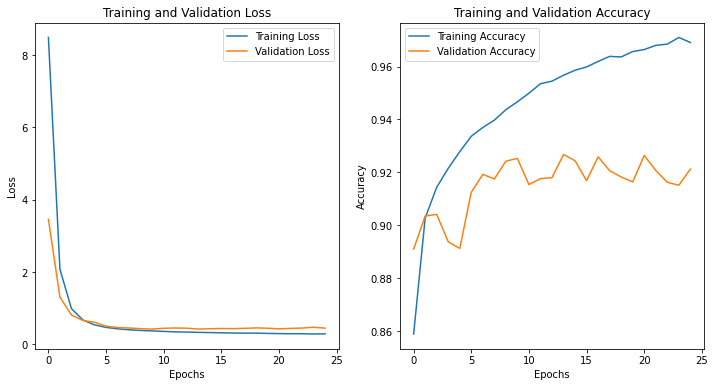

In [ ]:
plotLossAccGraph(history)

In [ ]:
# Evaluating performance on train dataset
loss, acc = model.evaluate(X_train, y_train)
print('  - Train data: loss %.3f - acc %.3f' % (loss, acc))

1875/1875 [==============================] - 5s 3ms/step - loss: 0.2789 - accuracy: 0.9737
  - Train data: loss 0.279 - acc 0.974


In [ ]:
# Evaluating performance on cross-validation dataset
loss, acc = model.evaluate(X_val, y_val)
print('  - Cross-val data: loss %.3f - acc %.3f' % (loss, acc))

250/250 [==============================] - 1s 3ms/step - loss: 0.4464 - accuracy: 0.9212
  - Cross-val data: loss 0.446 - acc 0.921


In [ ]:
# Evaluating performance of second model on test dataset
loss, acc = model.evaluate(X_test, y_test)
print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

63/63 [==============================] - 0s 4ms/step - loss: 0.4501 - accuracy: 0.9200
  - Test data: loss 0.450 - acc 0.920


### Observations and conclusions from second model
The model achieves:     
* Training accuracy - 97.3%
* Cross-validation accuracy - 92.1%
* Test accuracy - 92%

<br>

| Model | Training acc | Cross-val acc | Test acc |
| :----: | :----: | :----:| :----: |
| Baseline model | 99% | 91.6% | 90% |
| L2 Regularization | 97.3% | 92.1% | 92% |

<br>
After L2 regularization, over-fitting has been reduced. Training accuracy fell from 99% to 97.3%, cross-val accuracy rose from 91.6% to 92.1% and test accuracy rose by 2% to 92%.

### What is dropout regularization?
> Dropout works by randomly dropping out (setting to zero) a number of output features (or nodes) of a layer during training. 

The dropout rate controls the fraction of the nodes that are dropped out.

I will add dropout to the model, in addition to the existing l2 regularization.

Each of these callbacks gets called by TensorFlow after every epoch.  
The ```EarlyStopping``` callback stops training if the validation accuracy does not improve anymore. With patience, we set the number of epochs to wait before stopping when TensorFlow sees no progress.  
The ```ReduceLROnPlateau``` callback automatically reduces the learning rate if it doesn’t see any improvement.

In [22]:
def create_callbacks():
  early_stopping = EarlyStopping(patience=10, monitor='val_loss', verbose=1)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=0.00001,
                                patience=5, mode='min',
                                verbose=1)

In [23]:
# define cnn model 3 with dropout AND regularization
def define_model3():
  l2 = regularizers.l2(0.0002)
  model = tf.keras.Sequential([
    # first convolutional layer
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu', kernel_regularizer=l2, input_shape=(28,28,1)),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.20),

    # second convolutional layer
    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu', kernel_regularizer=l2),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.30),

    # third convolutional layer
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
    BatchNormalization(),    
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.40),   

    # fully connected classifier
    Flatten(), 
    Dense(1024, activation='relu', kernel_regularizer=l2),
    Dropout(0.30),
    Dense(512, activation='relu', kernel_regularizer=l2),
    Dropout(0.20),
    Dense(10, activation='softmax')
    ])
  # compile model
  opt = Adam(learning_rate=0.0001, decay=1e-6)
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [24]:
# Training our third model
# train on X_train/y_train & cross-validate on X_val/y_val
model = define_model3()
model.summary()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2, callbacks=create_callbacks())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 batch_normalization_13 (Bat  (None, 26, 26, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                      

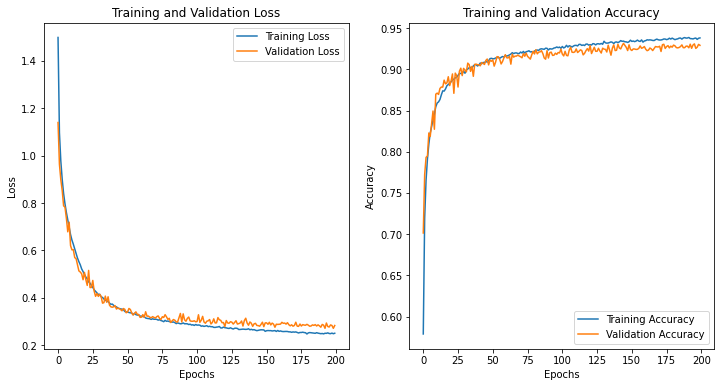

In [31]:
plotLossAccGraph(history)

In [26]:
# Evaluating performance on train dataset
loss, acc = model.evaluate(X_train, y_train)
print('  - Train data: loss %.3f - acc %.3f' % (loss, acc))

1875/1875 [==============================] - 7s 4ms/step - loss: 0.1188 - accuracy: 0.9987
  - Train data: loss 0.119 - acc 0.999


In [27]:
# Evaluating performance on cross-validation dataset
loss, acc = model.evaluate(X_val, y_val)
print('  - Cross-val data: loss %.3f - acc %.3f' % (loss, acc))

250/250 [==============================] - 1s 4ms/step - loss: 0.3657 - accuracy: 0.9399
  - Cross-val data: loss 0.366 - acc 0.940


In [28]:
# Evaluating performance of second model on test dataset
loss, acc = model.evaluate(X_test, y_test)
print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

63/63 [==============================] - 1s 5ms/step - loss: 0.3878 - accuracy: 0.9360
  - Test data: loss 0.388 - acc 0.936


### Observations and conclusions from third model
The model achieves:     
* Training accuracy - 99.9%
* Cross-validation accuracy - 94%
* Test accuracy - 93.6%

<br>

| Model | Training acc | Cross-val acc | Test acc |
| :----: | :----: | :----:| :----: |
| Baseline model | 99% | 91.6% | 90% |
| L2 Regularization | 97.3% | 92.1% | 92% |
| L2 Regularization & dropout | 99.9% | 94% | 93.6% |

<br>

Over-fitting has been further reduced. Cross-val accuracy went up by 1.5% and test accuracy rose by 1.7% to 93.7%.



### Image augmentation

> Data augmentation is a technique to artificially create new training data from existing training data. 

Using Keras, we can generate transformed images by applying random transformations to an existing image, such as flipping, zooming, rotation, shearing etc. 



In [29]:
train_datagen = ImageDataGenerator( 
        rotation_range=10,        # randomly rotate between 0-rotation_range angle
        width_shift_range=0.2,    # randomly shift horizontally by this much
        height_shift_range=0.2,   # randomly shift vertically by this much
        shear_range=0.2,          # randomly shear by this much
        zoom_range=0.2,           # randomly zoom (80% - 120%)
        horizontal_flip=True,
        fill_mode='nearest'       # fill any pixels lost in xform with nearest
    )
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# fit the data generator on training data & validate on
num_train_batches = len(X_train) // 64
num_train_batches += (0 if len(X_train) % 64 == 0 else 1)     
num_val_batches = len(X_val) // 64
num_val_batches += (0 if len(X_val) % 64 == 0 else 1)     
num_test_batches = len(X_test) // 64
num_test_batches += (0 if len(X_test) % 64 == 0 else 1)

train_generator = train_datagen.flow(X_train, y_train, 
                                         batch_size=64,
                                         seed=123)
val_generator = train_datagen.flow(X_val, y_val, 
                                         batch_size=64,
                                         seed=123)
test_generator = test_datagen.flow(X_test, y_test, 
                                       batch_size=64,
                                       seed=123)

In [30]:
model = define_model3()
history = model.fit_generator(train_generator,
                                  steps_per_epoch = num_train_batches, 
                                  epochs = 200,
                                  validation_data = val_generator,
                                  validation_steps = num_val_batches)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/200
938/938 [==============================] - 31s 31ms/step - loss: 1.4981 - accuracy: 0.5788 - val_loss: 1.1394 - val_accuracy: 0.7014
Epoch 2/200
938/938 [==============================] - 29s 31ms/step - loss: 1.0967 - accuracy: 0.7191 - val_loss: 0.9636 - val_accuracy: 0.7722
Epoch 3/200
938/938 [==============================] - 29s 31ms/step - loss: 0.9770 - accuracy: 0.7653 - val_loss: 0.8982 - val_accuracy: 0.7931
Epoch 4/200
938/938 [==============================] - 29s 31ms/step - loss: 0.8994 - accuracy: 0.7911 - val_loss: 0.8530 - val_accuracy: 0.7949
Epoch 5/200
938/938 [==============================] - 29s 31ms/step - loss: 0.8399 - accuracy: 0.8092 - val_loss: 0.7879 - val_accuracy: 0.8227
Epoch 6/200
938/938 [==============================] - 27s 29ms/step - loss: 0.7964 - accuracy: 0.8228 - val_loss: 0.7825 - val_accuracy: 0.8186
Epoch 7/200
938/938 [==============================] - 28s 30ms/step - loss: 0.7601 - accuracy: 0.8304 - val_loss: 0.7355 - val_ac

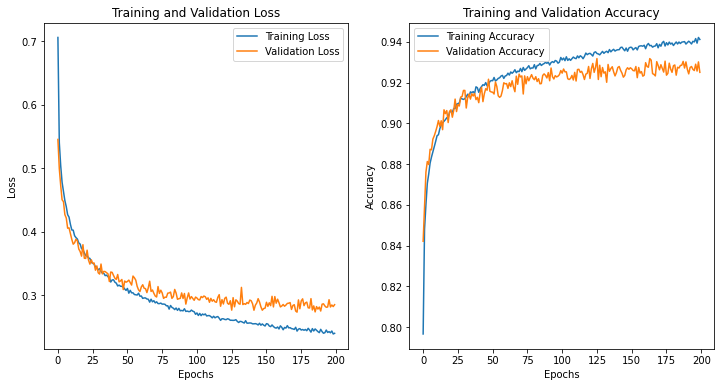

In [ ]:
plotLossAccGraph(history)

In [32]:
# Evaluating performance on train dataset
loss, acc = model.evaluate(X_train, y_train)
print('  - Train data: loss %.3f - acc %.3f' % (loss, acc))

1875/1875 [==============================] - 9s 5ms/step - loss: 0.2280 - accuracy: 0.9465
  - Train data: loss 0.228 - acc 0.946


In [33]:
# Evaluating performance on cross-validation dataset
loss, acc = model.evaluate(X_val, y_val)
print('  - Cross-val data: loss %.3f - acc %.3f' % (loss, acc))

250/250 [==============================] - 1s 4ms/step - loss: 0.3254 - accuracy: 0.9184
  - Cross-val data: loss 0.325 - acc 0.918


In [34]:
# Evaluating performance of second model on test dataset
loss, acc = model.evaluate(X_test, y_test)
print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

63/63 [==============================] - 1s 5ms/step - loss: 0.3099 - accuracy: 0.9240
  - Test data: loss 0.310 - acc 0.924


### Observations and conclusions from third model with image augmentation
The model achieves:     
* Training accuracy - 94.6%
* Cross-validation accuracy - 91.8%
* Test accuracy - 92.4%

<br>

| Model | Training acc | Cross-val acc | Test acc |
| :----: | :----: | :----:| :----: |
| Baseline model | 99% | 91.6% | 90% |
| L2 Regularization | 97.3% | 92.1% | 92% |
| L2 Regularization & dropout | 99.9% | 94% | 93.6% |
| L2 Regularization & dropout with augmentation | 94.6% | 91.8% | 92.4% |

<br>

The val accuracy fell from 93.6% to 92.4%. The divergence between cross-val loss and tran loss also increased.  
Hence, model 3 still performed the best out of the other models.
